In [4]:
import os
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader

from apn import APN
from data.cub import CUBDatasetSimple

In [14]:
test_transforms = T.Compose([
    T.Resize(size=448, antialias=True),
    T.CenterCrop(size=448),
    T.ToTensor()
])

dataset_val = CUBDatasetSimple(os.path.join('datasets', 'CUB'), split='val', transforms=test_transforms)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=1, shuffle=False)
dataloader_val_iter = iter(dataloader_val)

In [15]:
net = APN(attr_class_map=dataset_val.attr_class_map, k=107, attr_groups=dataset_val.attr_groups)
state_dict = torch.load('checkpoints/checkpoint.pt', map_location='cpu')
net.load_state_dict(state_dict)

<All keys matched successfully>

In [49]:
net.eval()
with torch.no_grad():
    images, class_tgts, attr_tgts = next(dataloader_val_iter)
    final_logits, local_logits, attn_maps, prototypes, max_logit_coords = net(images)

In [26]:
attn_maps.shape

torch.Size([1, 107, 14, 14])

In [27]:
dataset_val.attribute_df

,attribute_name,part_name,part_id
1,has_bill_shape::dagger,head,0
4,has_bill_shape::hooked_seabird,head,0
6,has_bill_shape::all-purpose,head,0
7,has_bill_shape::cone,head,0
10,has_wing_color::brown,wing,6
...,...,...,...
305,has_crown_color::white,head,0
308,has_wing_pattern::solid,wing,6
309,has_wing_pattern::spotted,wing,6
310,has_wing_pattern::striped,wing,6


In [53]:
dataset_val.attr_class_map[0] / 100

tensor([0.0292, 0.5985, 0.0365, 0.0584, 0.4590, 0.2459, 0.0000, 0.3197, 0.0328,
        0.2869, 0.4865, 0.2072, 0.0000, 0.2342, 0.0270, 0.2973, 0.2979, 0.3936,
        0.0000, 0.2340, 0.0851, 0.1809, 0.7850, 0.0374, 0.1776, 0.4423, 0.2115,
        0.0000, 0.2212, 0.0192, 0.3077, 0.2396, 0.3176, 0.2235, 0.2235, 0.1647,
        0.2235, 0.0720, 0.3680, 0.3393, 0.3304, 0.0000, 0.2143, 0.0268, 0.1964,
        0.2357, 0.0000, 0.2000, 0.0786, 0.2857, 0.8106, 0.8227, 0.0993, 0.0145,
        0.1449, 0.2971, 0.0000, 0.1159, 0.3116, 0.3516, 0.2747, 0.3077, 0.1978,
        0.2198, 0.4015, 0.2652, 0.0000, 0.1818, 0.0530, 0.2348, 0.2584, 0.2921,
        0.0000, 0.2135, 0.0787, 0.2584, 0.1376, 0.2018, 0.5859, 0.1818, 0.2020,
        0.4574, 0.1489, 0.3617, 0.8171, 0.4832, 0.2483, 0.0000, 0.2685, 0.0268,
        0.2416, 0.2708, 0.3958, 0.1042, 0.3475, 0.3262, 0.2199, 0.0213, 0.2411,
        0.3262, 0.0000, 0.2128, 0.1135, 0.5357, 0.0536, 0.2143, 0.1964])

In [51]:
class_tgts

tensor([0])

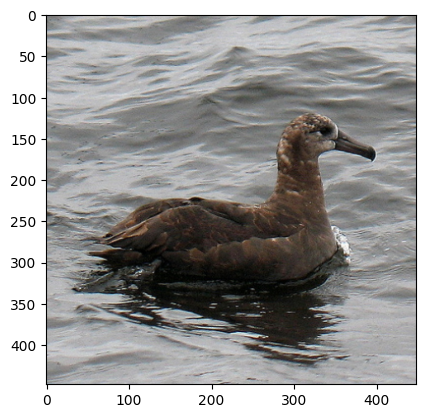

In [52]:
plt.imshow(images.squeeze().permute(1,2,0).numpy())